In [8]:
### IPYTHON=1 IPYTHON_OPTS=notebook PYSPARK_PYTHON=python3 pyspark

In [7]:
import os, sys

In [9]:
from pyspark.sql import SQLContext

In [13]:
sql = SQLContext(sc)

In [32]:
from pyspark.sql import SQLContext, Row
import datetime
from collections import namedtuple
import numpy as np

In [27]:
RFScenario = namedtuple('RFScenario', ('rf', 'date', 'neutral', 'scenarios'))

In [188]:
def construct_scenarios_type(number_scenarios=250, name = 'Scenarios'):
    names = ['rf', 'date', 'neutral']
    scenario_cols = ["s%d"%x for x in range(1,number_scenarios+1)]
    names.extend(scenario_cols)
    Scenarios = namedtuple('Scenarios', names)
    return Scenarios, scenario_cols

In [197]:
Scenarios, scenario_cols = construct_scenarios_type()

In [200]:
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector, _convert_to_vector 
def parse(row):
    DATE_FMT = "%Y-%m-%d"
    row[0] = row[0]
    row[1] = datetime.datetime.strptime(row[1], DATE_FMT)
    for i in np.arange(2,len(row)):
        row[i] = float(row[i])
    return RFScenario(row[0], row[1], row[2], DenseVector(row[3:6]))


def parse_explicit(row):
    DATE_FMT = "%Y-%m-%d"
    row[0] = row[0]
    row[1] = datetime.datetime.strptime(row[1], DATE_FMT)
    for i in np.arange(2,len(row)):
        row[i] = float(row[i])
    return Scenarios(*row)



In [191]:
csv_filename = "data/scenarios2.csv"

In [199]:
lines = sc.textFile(csv_filename)
parts = lines.map(lambda l: l.split(","))
rows = parts.map(parse)

In [203]:
rows_exp = parts.map(parse_explicit)
df_exp = sqlContext.createDataFrame(rows_exp)

In [205]:
df_exp.head(1)

[Row(rf='RF1', date=datetime.datetime(2015, 4, 14, 0, 0), neutral=35.03, s1=34.67865912475935, s2=35.19309272805697, s3=35.61162381981636, s4=34.92090026310803, s5=35.2757534118607, s6=34.88538726175033, s7=34.7947997828024, s8=34.422262176432426, s9=35.32719209964416, s10=35.70279197608641, s11=34.70929644638722, s12=35.16468125943031, s13=34.7083308292015, s14=34.6909371576162, s15=34.24743006243561, s16=35.18043521116673, s17=35.26710783535421, s18=34.68646893255419, s19=35.42074885668956, s20=35.10073110319397, s21=34.62729258634153, s22=34.590238555794265, s23=35.12518904748294, s24=34.54164263329866, s25=34.780562034944296, s26=35.009313286776944, s27=35.19898478845906, s28=34.22306349493622, s29=35.58776307961069, s30=34.86817402539321, s31=34.904330793280025, s32=34.501576221982006, s33=34.908487404457446, s34=34.927195922549025, s35=35.26215239163238, s36=33.92269249584361, s37=34.30733618265355, s38=34.834677237655015, s39=34.62744354378543, s40=34.77382130417254, s41=34.7282

In [226]:
scenario_dates = df_exp.groupBy('date').sum()
var_rdd = scenario_dates.map(lambda r: (r[0], r[1], float(var(np.array(r[2:]) - r[1]))))
df_var = sql.createDataFrame(var_rdd, schema=['date', 'neutral', 'var'])

<IPython.core.display.Javascript object>


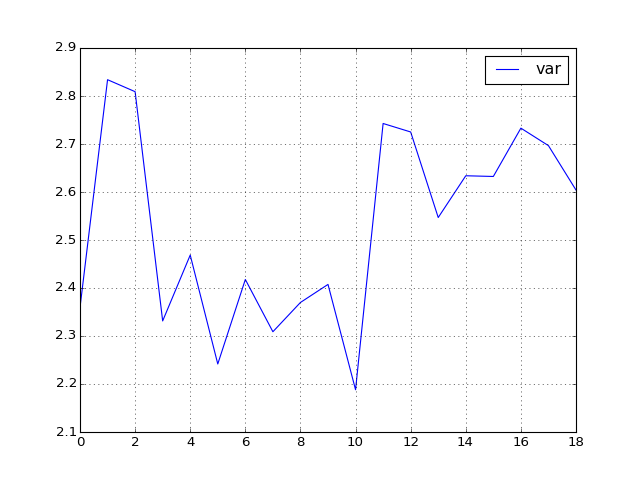

In [224]:
%matplotlib notebook
df_var.toPandas().plot()

In [158]:
df_exp = sqlContext.createDataFrame(rows_exp)
df_exp.head(2)

[Row(rf='RF1', date=datetime.datetime(2015, 4, 14, 0, 0), neutral=35.03, s1=34.67865912475935, s2=35.19309272805697, s3=35.61162381981636, s4=34.92090026310803, s5=35.2757534118607, s6=34.88538726175033, s7=34.7947997828024, s8=34.422262176432426, s9=35.32719209964416, s10=35.70279197608641, s11=34.70929644638722, s12=35.16468125943031, s13=34.7083308292015, s14=34.6909371576162, s15=34.24743006243561, s16=35.18043521116673, s17=35.26710783535421, s18=34.68646893255419, s19=35.42074885668956, s20=35.10073110319397, s21=34.62729258634153, s22=34.590238555794265, s23=35.12518904748294, s24=34.54164263329866, s25=34.780562034944296, s26=35.009313286776944, s27=35.19898478845906, s28=34.22306349493622, s29=35.58776307961069, s30=34.86817402539321, s31=34.904330793280025, s32=34.501576221982006, s33=34.908487404457446, s34=34.927195922549025, s35=35.26215239163238, s36=33.92269249584361, s37=34.30733618265355, s38=34.834677237655015, s39=34.62744354378543, s40=34.77382130417254, s41=34.7282

In [33]:
df = sqlContext.createDataFrame(rows)
df.head(2)

[Row(rf='RF1', date=datetime.datetime(2015, 4, 14, 0, 0), neutral=35.03, scenarios=DenseVector([34.6787, 35.1931, 35.6116])),
 Row(rf='RF1', date=datetime.datetime(2015, 4, 15, 0, 0), neutral=35.2, scenarios=DenseVector([35.3591, 35.7673, 35.0936]))]

In [122]:
f = sql.udf.register("fadd", lambda x: (np.array(x[3]) * 3.1).tolist(), ArrayType(FloatType()))
fagg = sql.udf.register("fagg", lambda x,y: (np.array(x[3]) + np.array(y[3])).tolist(), ArrayType(FloatType()))

In [76]:
sql.registerDataFrameAsTable(df, 'scen')

In [128]:
sql.sql('select date, fadd(scenarios) from scen group by date').collect()

Py4JJavaError: An error occurred while calling o111.sql.
: org.apache.spark.sql.AnalysisException: expression 'pythonUDF' is neither present in the group by, nor is it an aggregate function. Add to group by or wrap in first() if you don't care which value you get.;
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$class.failAnalysis(CheckAnalysis.scala:38)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.failAnalysis(Analyzer.scala:42)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$$anonfun$checkAnalysis$1.org$apache$spark$sql$catalyst$analysis$CheckAnalysis$class$$anonfun$$checkValidAggregateExpression$1(CheckAnalysis.scala:95)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$$anonfun$checkAnalysis$1$$anonfun$apply$4.apply(CheckAnalysis.scala:111)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$$anonfun$checkAnalysis$1$$anonfun$apply$4.apply(CheckAnalysis.scala:111)
	at scala.collection.immutable.List.foreach(List.scala:318)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$$anonfun$checkAnalysis$1.apply(CheckAnalysis.scala:111)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$$anonfun$checkAnalysis$1.apply(CheckAnalysis.scala:50)
	at org.apache.spark.sql.catalyst.trees.TreeNode.foreachUp(TreeNode.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$foreachUp$1.apply(TreeNode.scala:97)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$foreachUp$1.apply(TreeNode.scala:97)
	at scala.collection.immutable.List.foreach(List.scala:318)
	at org.apache.spark.sql.catalyst.trees.TreeNode.foreachUp(TreeNode.scala:97)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$class.checkAnalysis(CheckAnalysis.scala:50)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.checkAnalysis(Analyzer.scala:42)
	at org.apache.spark.sql.SQLContext$QueryExecution.assertAnalyzed(SQLContext.scala:920)
	at org.apache.spark.sql.DataFrame.<init>(DataFrame.scala:131)
	at org.apache.spark.sql.DataFrame$.apply(DataFrame.scala:51)
	at org.apache.spark.sql.SQLContext.sql(SQLContext.scala:744)
	at sun.reflect.GeneratedMethodAccessor53.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:744)


In [56]:
gdf = df.groupby('date')
# .agg({'neutral':'f'})

In [129]:
gdf.agg?

In [206]:
def var(scenarios, level=99, neutral_scenario=0):
    pnls = scenarios - neutral_scenario
    return - np.percentile(pnls, 100-level, interpolation='linear')